In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#!/usr/bin/env python3

seed_value=42

import os
import sys
import random as rn

from fastai.vision import *
from fastai.metrics import error_rate

import shutil

# -----------------------------
#from google.colab import drive
#from os import walk

#drive.mount('/content/gdrive')
# -----------------------------


# -----------------------------
# Make everything deterministic
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
rn.seed(seed_value)

import torch

torch.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# -----------------------------

from subprocess import check_output
nvidia_smi_ = [0, 0]

def nvidia_smi(nvidia_smi_):
    old_nvidia_smi_ = nvidia_smi_[1]
    nvidia_smi_now  = int(check_output(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader']))
    nvidia_smi_[0]  = nvidia_smi_now
    nvidia_smi_[1]  = nvidia_smi_now - old_nvidia_smi_
    return nvidia_smi_ 

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_))

torch.cuda.empty_cache()

from datetime import datetime
currtime = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

caddy_gestures_dataset_dir   = 'all-scenarios-split-cristal-clear-vs-cloudy-and-dark'
caddy_gestures_dataset_fname = caddy_gestures_dataset_dir + '.zip'
caddy_gestures_dataset_url   = 'http://caddy-underwater-datasets.ge.issia.cnr.it/assets/caddy-gestures-TMP/' + caddy_gestures_dataset_fname

nvidia-smi memory usage/increment: [11, 11]


In [2]:
!wget "$caddy_gestures_dataset_url"

--2019-09-16 08:24:24--  http://caddy-underwater-datasets.ge.issia.cnr.it/assets/caddy-gestures-TMP/all-scenarios-split-cristal-clear-vs-cloudy-and-dark.zip
Resolving caddy-underwater-datasets.ge.issia.cnr.it (caddy-underwater-datasets.ge.issia.cnr.it)... 150.145.4.194
Connecting to caddy-underwater-datasets.ge.issia.cnr.it (caddy-underwater-datasets.ge.issia.cnr.it)|150.145.4.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540347170 (1.4G) [application/zip]
Saving to: ‘all-scenarios-split-cristal-clear-vs-cloudy-and-dark.zip’

all-scenarios-split 100%[===================>]   1.43G  10.3MB/s    in 2m 22s  

2019-09-16 08:26:48 (10.3 MB/s) - ‘all-scenarios-split-cristal-clear-vs-cloudy-and-dark.zip’ saved [1540347170/1540347170]



In [3]:
!md5sum "$caddy_gestures_dataset_fname"
print('88dd6fbfc8176d6845dd0f55f95c0c5b  all-scenarios-split-cristal-clear-vs-cloudy-and-dark.zip')

88dd6fbfc8176d6845dd0f55f95c0c5b  all-scenarios-split-cristal-clear-vs-cloudy-and-dark.zip
88dd6fbfc8176d6845dd0f55f95c0c5b  all-scenarios-split-cristal-clear-vs-cloudy-and-dark.zip


In [4]:
!unzip "$caddy_gestures_dataset_fname"
!ls

Output hidden; open in https://colab.research.google.com to view.

# Splitting the dataset

![alt text](https://i.ibb.co/MGCWyCf/image.png)

In [0]:
models_specs = {}
models_specs['A'] = {}
models_specs['B'] = {}
models_specs['C'] = {}
models_specs['F'] = {}

scenarios = ['biograd-A', 'biograd-B', 'biograd-C', 'genova-A', 'brodarski-A', 'brodarski-B', 'brodarski-C', 'brodarski-D']

models_specs['A']['train'] = ['biograd-A', 'biograd-B']
models_specs['B']['train'] = ['genova-A']
models_specs['C']['train'] = ['brodarski-A', 'brodarski-C']
models_specs['F']['train'] = scenarios

split = [80, 20]             # test sets are all the scenarios picked up one by one
overall_split = [70, 20, 10] # except the "overall one" that is the union of all of them with this split (not a random split because the frames come from a video)

In [0]:
#curr_model = 'A'
curr_model = 'B'
#curr_model = 'C'
#curr_model = 'F'

In [7]:
path = Path(caddy_gestures_dataset_dir) / 'all-scenarios'
path.ls()

[PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/three'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/backwards'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/boat'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/carry'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/four'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/exceptions.txt'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/two'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/down'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/num_delimiter'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/start_comm'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/end_comm'),
 PosixPa

In [8]:
def find_all_dirs(directory: Path):   
    dir_list = [] # A list for storing directories existing in the provided path

    for x in directory.iterdir():
        if x.is_dir():
           dir_list.append(x)

    return dir_list
  
dir_list = find_all_dirs(path)

dir_list

[PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/three'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/backwards'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/boat'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/carry'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/four'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/two'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/down'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/num_delimiter'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/start_comm'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/end_comm'),
 PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/five'),
 PosixPath('all-sc

In [9]:
def find_all_files(directory: Path):   
    file_list = [] # A list for storing files existing in the provided path

    for x in directory.iterdir():
        if x.is_file():
           file_list.append(x)

    return file_list
  
for d in dir_list:
    subdir_list = find_all_dirs(d)
    print(subdir_list)                 # "crystal-clear", "cloudy-and-dark"
    print(d.stem, d)                   # "up", "all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/up"
    for sd in subdir_list:
        file_list = find_all_files(sd)
        print(file_list)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
from sklearn.model_selection import train_test_split

split_dataset_dir = 'caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-' + curr_model
split_path = Path(split_dataset_dir)
split_path.mkdir(exist_ok=True)
split_path.ls()

dataset_subdirs = ['train', 'valid', 'test']
all_dataset = {}

for ds in dataset_subdirs:
    (split_path / ds).mkdir(exist_ok=True)
    all_dataset[ds] = {}

file_lists = []

# Create train+valid sets and test sets
Create train+valid dataset and perform the split according to {split}
Create the test sets (8 + the "overall" one) using images that don't match training set requirements

In [11]:
import re

train_valid = {}
test        = {}

for sc in scenarios:               # biograd-A, biograd-B, ... , genova-A
    test[sc] = {}
test['overall'] = {}               # Behold! The 'overall' test set! Keep in mind that no training image can end up being also in the test set!

for sc in scenarios + ['overall']:
    for d in dir_list:             # gesture name: 'one', 'two', 'up', 'down', 'mosaic', ...
        train_valid[d.stem] = []
        test[sc][d.stem] = []

#print(test)
#print(scenarios)
    
for d in dir_list:
    '''                                 # use this to debug. "five" has less than 100 elements
    if d.stem != 'two':
        continue
    '''

    for ds in ['train', 'valid']:       # not test because test dir has a different structure to also account for different scenarios
        (split_path / ds / d.stem).mkdir(exist_ok=True)

    subdir_list = find_all_dirs(d)
    #print(subdir_list)                 # "crystal-clear", "cloudy-and-dark"
    print(80*'-')
    #print(d.stem, d)                   # "up", "all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/up"
    print(d.stem)
    print(80*'-')
    
    for sd in subdir_list:
        file_list = find_all_files(sd)
        print(file_list[:2])
        for f in file_list:
            scenarios_regex = ''
            for scenario in models_specs[curr_model]['train']:
                scenarios_regex += scenario + '|'                   # build a regexp with all the scenarios that will constitute the train+valid set (to decide with just 1 if)
            #print(scenario, f.stem, (scenario in f.stem))
            scenarios_regex = scenarios_regex[:-1]
            found = re.search(scenarios_regex, f.stem) 
            #print(f'Looking for: {scenarios_regex} in {f.stem}')
            if found:                                               # if the regexp with 'biograd-A|biograd-B' matches -> training set, else test set
                train_valid[d.stem].append(f)
                #print(f'Found: {scenarios_regex} in {f.stem}')
            else:
                sc_regex = '.*___(.*)_[0-9]*_.*'                    # ok, but which test set? we have 8 of them! extract the scenario from the filename and...
                sc = re.sub(sc_regex, '\\1', f.stem)
                if sc in scenarios:
                    #print(f'Found test scenario {sc}')
                    test[sc][d.stem].append(f)                      # ...add to the proper list
                    test['overall'][d.stem].append(f)               # and don't forget the overall scenario!
                    
        print(f'Found {len(train_valid[d.stem])} images in subdirectory "{sd.name}" matching training set requirements ({models_specs[curr_model]["train"]}) for model {curr_model}')

    print(f'Splitting train+valid set with {len(train_valid[d.stem])} images according to split {split} in a non-random (i.e. sequential) way')
    train_valid[d.stem].sort()
    print(f'Train+Valid: {train_valid[d.stem][:2]}')
    
    sz = int(len(train_valid[d.stem]) * split[0] / 100)
    train = train_valid[d.stem][:sz]
    valid = train_valid[d.stem][sz:]
    print(f'Train: {len(train)} - Valid: {len(valid)} - sz: {sz}')
    
    print(f'Train: {train[:2]}')
    print(f'Valid: {valid[:2]}')
    

#print(f'{len(train_valid[d.stem])} - Train+Valid: {train_valid[d.stem]}')

stemmed_test = {}

for sc in scenarios + ['overall']:
    stemmed_test[sc] = {}
    for d in dir_list:             # gesture name: 'one', 'two', 'up', 'down', 'mosaic', ...
        test[sc][d.stem].sort()
        stemmer = lambda x: x.stem
        stemmed_list = list(map(stemmer, test[sc][d.stem]))
        #print(f'Scenario {sc} - gesture {d.stem} - {len(test[sc][d.stem])} - Test: {test[sc][d.stem][:2]}')
        print(f'Scenario {sc} - gesture {d.stem} - {len(test[sc][d.stem])} - Test: {stemmed_list[:2]}...{stemmed_list[-2:]}')
        
        stemmed_test[sc][d.stem] = stemmed_list

--------------------------------------------------------------------------------
three
--------------------------------------------------------------------------------
[PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/three/crystal-clear/three___genova-A_01725_right.jpg'), PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/three/crystal-clear/three___genova-A_00651_left.jpg')]
Found 190 images in subdirectory "crystal-clear" matching training set requirements (['genova-A']) for model B
[PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/three/cloudy-and-dark/three___brodarski-D_00045_right.jpg'), PosixPath('all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/three/cloudy-and-dark/three___biograd-C_00387_left.jpg')]
Found 190 images in subdirectory "cloudy-and-dark" matching training set requirements (['genova-A']) for model B
Splitting train+valid set with 190 images according to split [80

# Export train/valid/test sets as CSV and pickle file

In [12]:
import pickle
train_valid_df = pd.DataFrame.from_dict(train_valid, orient='index')

print(train_valid_df)
train_valid_df.to_csv('/content/train_valid-df-model-' + curr_model + '.csv')

with open('/content/train_valid-df-model-' + curr_model + '.pkl', 'wb') as handle:
    pickle.dump(train_valid, handle, protocol=pickle.HIGHEST_PROTOCOL)


test_df = pd.DataFrame.from_dict(test)

print(test_df)
test_df.to_csv('/content/test-df-model-' + curr_model + '.csv')

with open('/content/test-df-model-' + curr_model + '.pkl', 'wb') as handle:
    pickle.dump(test, handle, protocol=pickle.HIGHEST_PROTOCOL)

                                                            0     ...                                               1117
three          all-scenarios-split-cristal-clear-vs-cloudy-an...  ...                                               None
backwards      all-scenarios-split-cristal-clear-vs-cloudy-an...  ...                                               None
boat           all-scenarios-split-cristal-clear-vs-cloudy-an...  ...                                               None
carry          all-scenarios-split-cristal-clear-vs-cloudy-an...  ...                                               None
four           all-scenarios-split-cristal-clear-vs-cloudy-an...  ...                                               None
two            all-scenarios-split-cristal-clear-vs-cloudy-an...  ...                                               None
down           all-scenarios-split-cristal-clear-vs-cloudy-an...  ...                                               None
num_delimiter  all-scenarios-spl

# Now perform the actual copy



In [13]:
for d in dir_list:
    sz = int(len(train_valid[d.stem]) * split[0] / 100)
    train = train_valid[d.stem][:sz]
    valid = train_valid[d.stem][sz:]
    print(f'Train: {len(train)} - Valid: {len(valid)} - sz: {sz}')
    
    dst_path = split_path / 'train' / d.stem
    for file in train:
        #print(f'Copying {file} to {dst_path}')
        shutil.copy(file, dst_path)
    dst_path = split_path / 'valid' / d.stem
    for file in valid:
        #print(f'Copying {file} to {dst_path}')
        shutil.copy(file, dst_path)


Train: 152 - Valid: 38 - sz: 152
Train: 278 - Valid: 70 - sz: 278
Train: 225 - Valid: 57 - sz: 225
Train: 558 - Valid: 140 - sz: 558
Train: 112 - Valid: 28 - sz: 112
Train: 192 - Valid: 48 - sz: 192
Train: 611 - Valid: 153 - sz: 611
Train: 424 - Valid: 106 - sz: 424
Train: 873 - Valid: 219 - sz: 873
Train: 459 - Valid: 115 - sz: 459
Train: 11 - Valid: 3 - sz: 11
Train: 244 - Valid: 62 - sz: 244
Train: 83 - Valid: 21 - sz: 83
Train: 144 - Valid: 36 - sz: 144
Train: 48 - Valid: 12 - sz: 48
Train: 894 - Valid: 224 - sz: 894


... and for the test sets

In [14]:
for sc in scenarios + ['overall']:
    (split_path / 'test' / sc).mkdir(exist_ok=True)
    for d in dir_list:             # gesture name: 'one', 'two', 'up', 'down', 'mosaic', ...
        test_dst_path = split_path / 'test' / sc / d.stem
        test_dst_path.mkdir(exist_ok=True)
        for file in test[sc][d.stem]:
            if '100' in str(file):
                print(f'Scenario {sc} - copying {file} to {test_dst_path}')
            shutil.copy(file, test_dst_path)

Scenario biograd-A - copying all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/boat/crystal-clear/boat___biograd-A_01004_left.jpg to caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test/biograd-A/boat
Scenario biograd-A - copying all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/boat/crystal-clear/boat___biograd-A_01004_right.jpg to caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test/biograd-A/boat
Scenario biograd-A - copying all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/boat/crystal-clear/boat___biograd-A_01005_left.jpg to caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test/biograd-A/boat
Scenario biograd-A - copying all-scenarios-split-cristal-clear-vs-cloudy-and-dark/all-scenarios/boat/crystal-clear/boat___biograd-A_01005_right.jpg to caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test/biograd-A/boat
Scenario biograd-A - copying all-s

# Verify what has been copied

For train and valid sets...

In [15]:
for d in dir_list:                             # 'up', 'down', 'carry'
    for ds in ['train', 'valid']:              # not test
        dst_path = split_path / ds / d.stem
        print(f'{len(dst_path.ls())} - {dst_path.ls()}')

152 - [PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/train/three/three___genova-A_01725_right.jpg'), PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/train/three/three___genova-A_00651_left.jpg'), PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/train/three/three___genova-A_01197_left.jpg'), PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/train/three/three___genova-A_01260_left.jpg'), PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/train/three/three___genova-A_01197_right.jpg'), PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/train/three/three___genova-A_02151_right.jpg'), PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/train/three/three___genova-A_01442_right.jpg'), PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/trai

... and for the test sets

In [16]:
for sc in scenarios + ['overall']:
    for d in dir_list:                             # 'up', 'down', 'carry'
        test_dst_path = split_path / 'test' / sc / d.stem
        print(f'{len(test_dst_path.ls())} - {test_dst_path} - {test_dst_path.ls()[:2]}')

100 - caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test/biograd-A/three - [PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test/biograd-A/three/three___biograd-A_00466_right.jpg'), PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test/biograd-A/three/three___biograd-A_00472_left.jpg')]
60 - caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test/biograd-A/backwards - [PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test/biograd-A/backwards/backwards___biograd-A_00506_right.jpg'), PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test/biograd-A/backwards/backwards___biograd-A_00512_left.jpg')]
52 - caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test/biograd-A/boat - [PosixPath('caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test/biograd-A/boat/boat___biograd-A_011

# Now the actual model (finally)

The dataset has 16 (16) classes: ['backwards', 'boat', 'carry', 'down', 'end_comm', 'five', 'four', 'here', 'mosaic', 'num_delimiter', 'one', 'photo', 'start_comm', 'three', 'two', 'up']
Training   set size is: (x: 5308, y: 5308)
Validation set size is: (x: 1332, y: 1332)


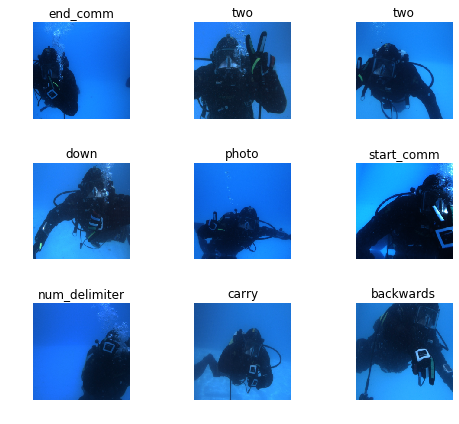

In [17]:
model_name = "resnet-50"
if model_name == "resnet-34":
    cnn_model = models.resnet34
    img_size  = 224
    epochs    = 10
    bs = 64
    # bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
else:
    cnn_model = models.resnet50
    img_size  = 224
    epochs    = 10
    bs = 32
    #bs = 4   # uncomment this line if you run out of memory even after clicking Kernel->Restart

tfms = get_transforms()
data = ImageDataBunch.from_folder(split_path, bs=bs, ds_tfms=tfms, size=img_size).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(7,6))

print(f'The dataset has {len(data.classes)} ({data.c}) classes: {data.classes}')
print(f'Training   set size is: (x: {len(data.train_dl.dl.dataset.x)}, y: {len(data.train_dl.dl.dataset.y)})')
print(f'Validation set size is: (x: {len(data.valid_dl.dl.dataset.x)}, y: {len(data.valid_dl.dl.dataset.y)})')

In [18]:
print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_))

learn = cnn_learner(data, cnn_model, metrics=accuracy)

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_))
print('Learner ready.')

nvidia-smi memory usage/increment: [398, 387]


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 110056098.90it/s]


nvidia-smi memory usage/increment: [456, 69]
Learner ready.


three torch.Size([480, 640])


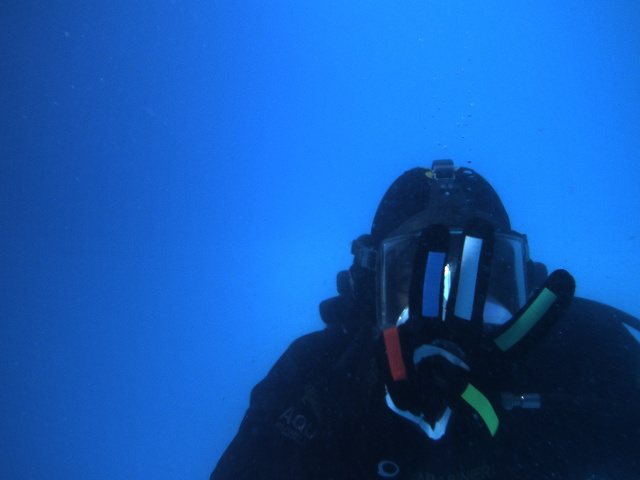

In [19]:
idx=100
img   = data.train_dl.dl.dataset.x[idx]
label = data.train_dl.dl.dataset.y[idx]
print(label, img.size)
img

backwards torch.Size([480, 640])


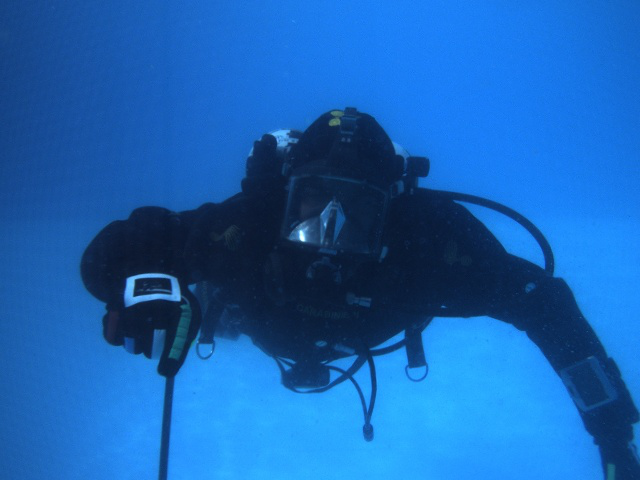

In [20]:
idx=101
img   = data.valid_dl.dl.dataset.x[idx]
label = data.valid_dl.dl.dataset.y[idx]
print(label, img.size)
img

# Training of the model with the newly created DataBunch

If you already performed these steps, go down and reload

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


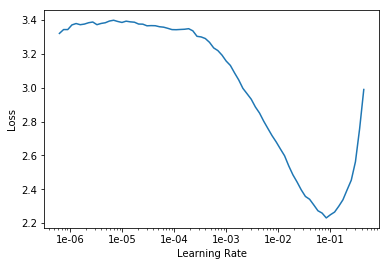

In [21]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-02

In [23]:
from fastai.callbacks import *

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_))

load_saved_model = False
savepath ='/content/'

if load_saved_model:
    print('Loading stage-1')
    #learn.load(savepath + model_name + '-stage-1')
    learn.load(savepath + 'resnet-50-stage-1-2019-07-11_16.24.10')
else:
    print(f'Training model: {model_name} for {epochs} epochs with batch size: {bs}')
    # if every=‘epoch’ the saved model filename also contains the epoch
    learn.fit_one_cycle(10, max_lr=lr, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name=savepath + model_name + '-stage-1-' + currtime)])
    learn.save(savepath + model_name + '-stage-1-' + currtime)

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_))

nvidia-smi memory usage/increment: [3651, 3582]
Training model: resnet-50 for 10 epochs with batch size: 32


nvidia-smi memory usage/increment: [3641, 59]


# Mount your Google Drive

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

savepath = Path('/content/gdrive/My Drive/Colab Notebooks/caddy-gestures-resnet-models/')
savepath.mkdir(exist_ok=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Optional

Choose whether to save the learner on your Google Drive or reload from it.

In [25]:
old_path = Path('/content')
old_path_files = old_path.ls()
for file in old_path_files:
    if model_name in str(file):
        print(f'Copying saved model: {file} to {savepath}')
        shutil.copy(file, savepath)

Copying saved model: /content/resnet-50-stage-1-2019-09-16_08.24.20.pth to /content/gdrive/My Drive/Colab Notebooks/caddy-gestures-resnet-models
Copying saved model: /content/resnet-50-stage-1-2019-09-16_08.24.20_4.pth to /content/gdrive/My Drive/Colab Notebooks/caddy-gestures-resnet-models
Copying saved model: /content/resnet-50-stage-1-2019-09-16_08.24.20_0.pth to /content/gdrive/My Drive/Colab Notebooks/caddy-gestures-resnet-models
Copying saved model: /content/resnet-50-stage-1-2019-09-16_08.24.20_8.pth to /content/gdrive/My Drive/Colab Notebooks/caddy-gestures-resnet-models
Copying saved model: /content/resnet-50-stage-1-2019-09-16_08.24.20_6.pth to /content/gdrive/My Drive/Colab Notebooks/caddy-gestures-resnet-models
Copying saved model: /content/resnet-50-stage-1-2019-09-16_08.24.20_2.pth to /content/gdrive/My Drive/Colab Notebooks/caddy-gestures-resnet-models
Copying saved model: /content/resnet-50-stage-1-2019-09-16_08.24.20_7.pth to /content/gdrive/My Drive/Colab Notebooks/ca

In [0]:
learn.load(savepath / (model_name + '-stage-1-2019-09-12_08.23.21_8'))

Learner(data=ImageDataBunch;

Train: LabelList (4320 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
three,three,three,three,three
Path: caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-A;

Valid: LabelList (1086 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
three,three,three,three,three
Path: caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-A;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=

In [0]:
print(f'Exporting the model as pickle file to {savepath}...')
learn.export(savepath / (model_name + '-stage-1-' + currtime + '.pkl'))           # export model as pickle file to be used "outside fast.ai"

Exporting the model as pickle file to /content/gdrive/My Drive/Colab Notebooks/caddy-gestures-resnet-models...


# Evaluate the model

At first, against the validation set

Plotting top losses for stage-1


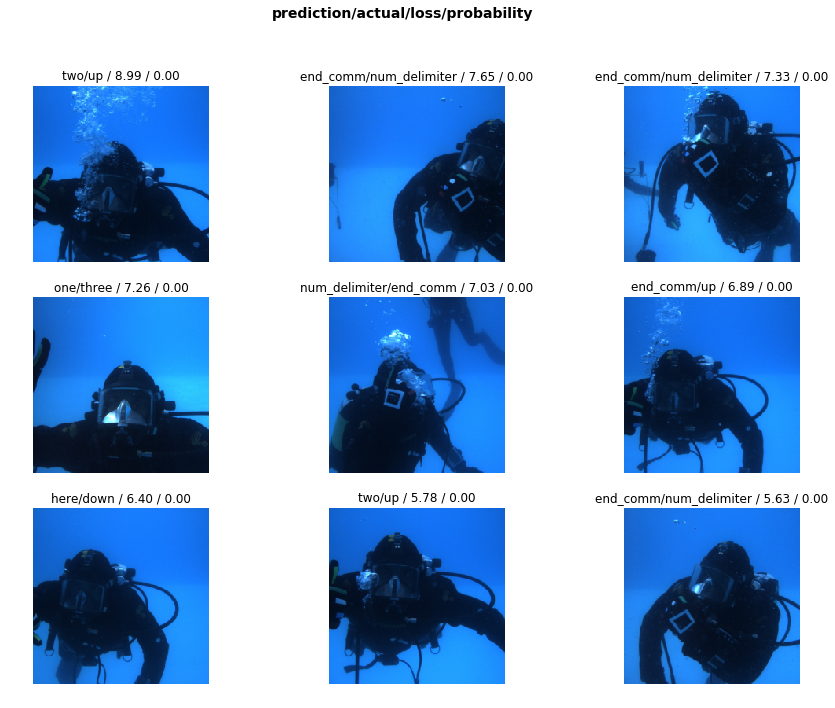

In [26]:
print('Interpreting result for stage-1')
interp = ClassificationInterpretation.from_learner(learn)
print('Plotting top losses for stage-1')
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

Plotting confusion matrix/top confused for stage-1


[('num_delimiter', 'end_comm', 9),
 ('end_comm', 'num_delimiter', 7),
 ('one', 'two', 6),
 ('three', 'two', 4),
 ('backwards', 'here', 3),
 ('down', 'here', 3),
 ('four', 'two', 3),
 ('one', 'here', 3),
 ('two', 'three', 3),
 ('up', 'carry', 3),
 ('up', 'two', 3),
 ('down', 'one', 2),
 ('down', 'two', 2),
 ('photo', 'one', 2),
 ('three', 'four', 2)]

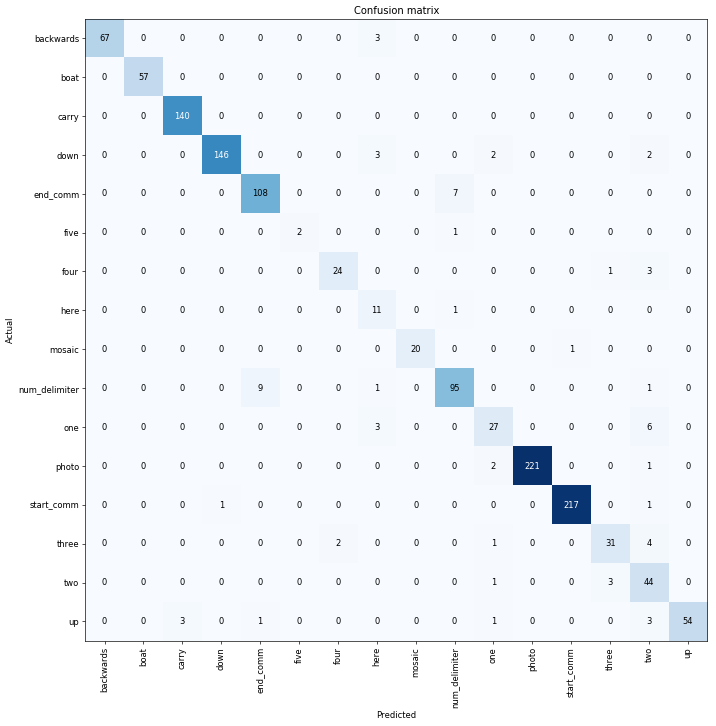

In [27]:
print('Plotting confusion matrix/top confused for stage-1')
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused(min_val=2)

# Let's also do some manual number crunching

Just because I can't find a quick way to extract accuracy inside the guts of Fast.ai after a call to **```validate()```** on the test set...

In [0]:
def evaluate_model_from_interp(interp, data):
  # perform a "manual" evaluation of the model to take a look at predictions vs. labels and to
  # re-compute accuracy from scratch (to double check and also because I didn't find a quick way
  # to extract accuracy inside the guts of Fast.ai after a call to validate() on the test set...)
  print(f'Interp has {len(interp.y_true)} ground truth labels: {interp.y_true}')
  print(f'Interp yielded {len(interp.preds)} raw predictions. First two raw predictions are: {interp.preds[:2]}')
  print(f'The problem had {len(data.classes)} classes: {data.classes}') # data.c is just len(data.classes)

  print('')
  print(f'Pred -> GroundTruth = PredLabel -> GroundTruthLabel')

  ok_pred = 0

  for idx, raw_p in enumerate(interp.preds):
      pred = np.argmax(raw_p)
      if idx < 10:
          print(f'{pred} -> {interp.y_true[idx]} = {data.classes[pred]} -> {data.valid_ds.y[idx]}')
      if pred == interp.y_true[idx]:
          ok_pred += 1

  acc = ok_pred / len(interp.y_true)
  print(f'Overall accuracy of the model: {acc:0.5f}')
  return acc

In [29]:
evaluate_model_from_interp(interp, data)

Interp has 1332 ground truth labels: tensor([13, 13, 13,  ..., 11, 11, 11])
Interp yielded 1332 raw predictions. First two raw predictions are: tensor([[2.6215e-09, 7.2614e-09, 1.2701e-09, 6.5206e-08, 8.9046e-07, 3.0724e-08,
         7.2413e-06, 2.7081e-09, 8.0449e-07, 1.8719e-07, 2.1360e-06, 1.3382e-06,
         8.6211e-09, 9.9829e-01, 1.6947e-03, 3.3683e-10],
        [8.9105e-05, 2.4885e-04, 1.4322e-04, 8.0841e-04, 2.9952e-05, 4.2813e-04,
         7.2855e-01, 5.3466e-04, 1.1376e-02, 6.9633e-06, 6.4744e-05, 1.2091e-03,
         2.8477e-05, 2.4634e-01, 9.8568e-03, 2.8399e-04]])
The problem had 16 classes: ['backwards', 'boat', 'carry', 'down', 'end_comm', 'five', 'four', 'here', 'mosaic', 'num_delimiter', 'one', 'photo', 'start_comm', 'three', 'two', 'up']

Pred -> GroundTruth = PredLabel -> GroundTruthLabel
13 -> 13 = three -> three
6 -> 13 = four -> three
13 -> 13 = three -> three
10 -> 13 = one -> three
13 -> 13 = three -> three
13 -> 13 = three -> three
13 -> 13 = three -> three
13

0.948948948948949

# Fast.ai doesn't provide an `evaluate()`-like function as in Keras

![alt text](https://i.ibb.co/86k8rFN/image.png)

So it's not possible to have a labeled test set in the same databunch used for training/validation of the model. Ok, let's follow the advice and build another databunch with training and test set (used as validation set). <spoiler> In Keras there's a handy [model.evaluate()](https://keras.io/models/model/#evaluate) function to test the model. </spoiler>

# Batch construction of 8+1 ImageDataBunch

To batch-test the model against each of them

Executing rsync -a --progress caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/train caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test
Picking up images from caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B directory...
Creating test DataBunch data_test[biograd-A]
The dataset has 16 (16) classes: ['backwards', 'boat', 'carry', 'down', 'end_comm', 'five', 'four', 'here', 'mosaic', 'num_delimiter', 'one', 'photo', 'start_comm', 'three', 'two', 'up']
Training   set size is: (x: 5308, y: 5308)
Validation set size is: (x: 3456, y: 3456)
Creating test DataBunch data_test[biograd-B]
The dataset has 16 (16) classes: ['backwards', 'boat', 'carry', 'down', 'end_comm', 'five', 'four', 'here', 'mosaic', 'num_delimiter', 'one', 'photo', 'start_comm', 'three', 'two', 'up']
Training   set size is: (x: 5308, y: 5308)
Validation set size is: (x: 1950, y: 1950)
Creating test DataBunch data_test[biograd-C]
The dataset has 16 (16) class

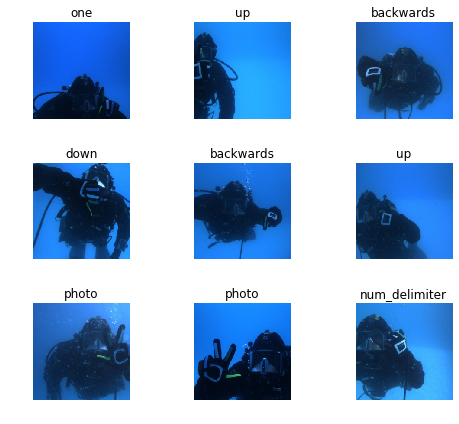

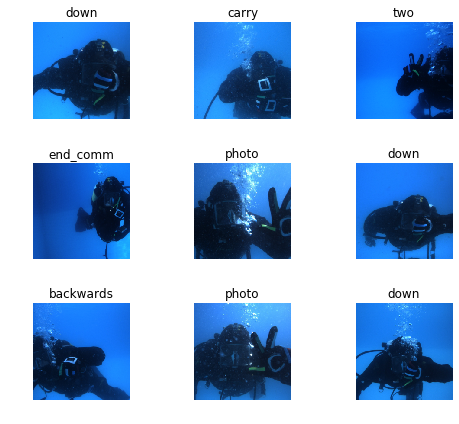

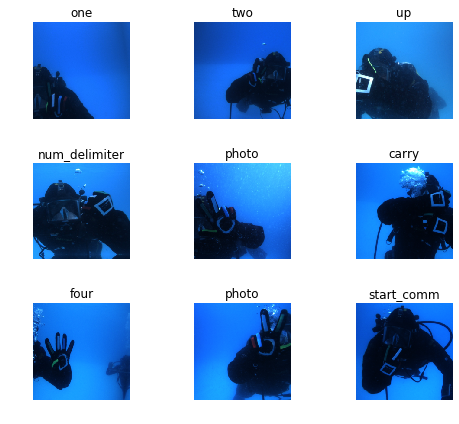

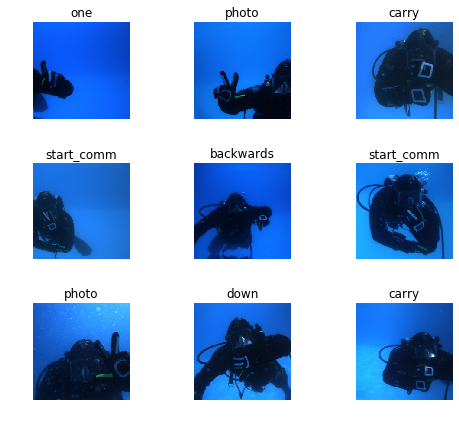

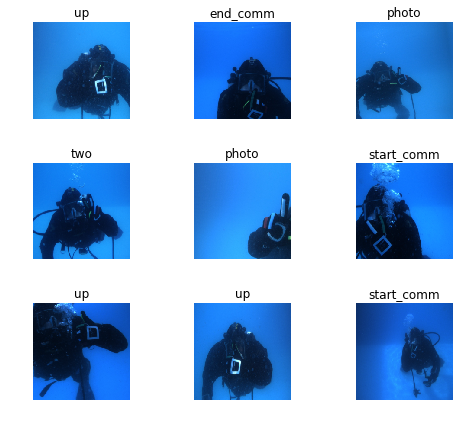

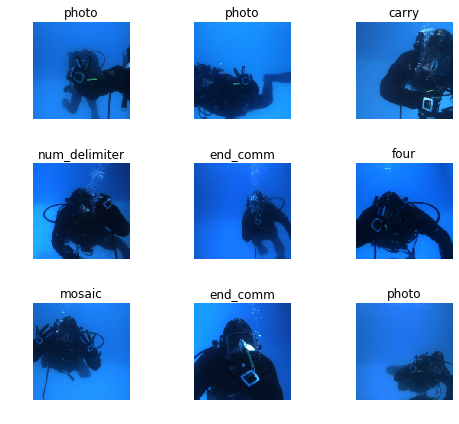

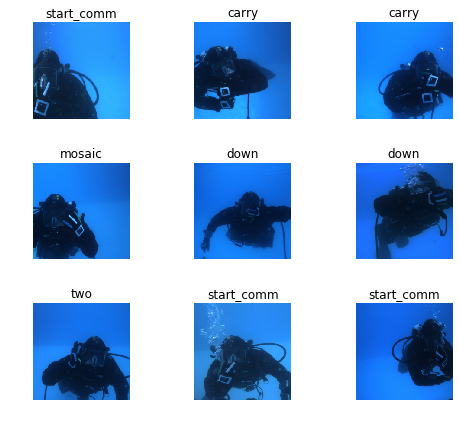

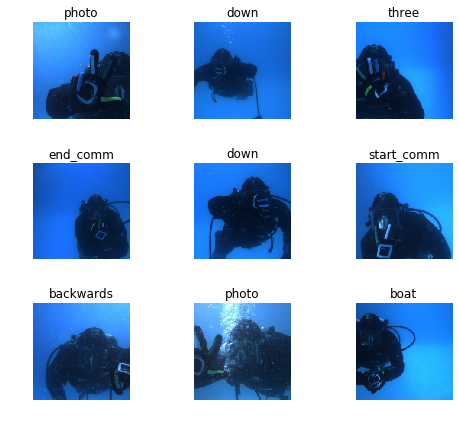

In [30]:
train_path = split_path / 'train'
test_path  = split_path / 'test'

!echo "Executing rsync -a --progress" "$train_path" "$test_path"
!rsync -a "$train_path" "$test_path"                            # rsync the whole 'train' dir to make Fast.ai pick up the correct scenario as validation set
 
print(f'Picking up images from {split_path} directory...')

data_test = {}

tfms = get_transforms()
for sc in scenarios + ['overall']:                              # 8+1 scenarios
    if sc not in models_specs[curr_model]['train']:             # but skip the scenarios used to train the model
        print(f'Creating test DataBunch data_test[{sc}]')
        data_test[sc] = ImageDataBunch.from_folder(test_path, train='train', valid=sc, bs=bs, ds_tfms=tfms, size=img_size).normalize(imagenet_stats)
        
        data_t = data_test[sc]
        data_t.show_batch(rows=3, figsize=(7,6))
        
        print(f'The dataset has {len(data_t.classes)} ({data_t.c}) classes: {data_t.classes}')
        print(f'Training   set size is: (x: {len(data_t.train_dl.dl.dataset.x)}, y: {len(data_t.train_dl.dl.dataset.y)})')
        print(f'Validation set size is: (x: {len(data_t.valid_dl.dl.dataset.x)}, y: {len(data_t.valid_dl.dl.dataset.y)})')

In [31]:
idx=100
img   = data_test['genova-A'].train_dl.dl.dataset.x[idx]
label = data_test['genova-A'].train_dl.dl.dataset.y[idx]
print(label, img.size)
img

KeyError: ignored

In [32]:
idx=102
img   = data_test['genova-A'].valid_dl.dl.dataset.x[idx]
label = data_test['genova-A'].valid_dl.dl.dataset.y[idx]
print(label, img.size)
img

KeyError: ignored

three torch.Size([480, 640])


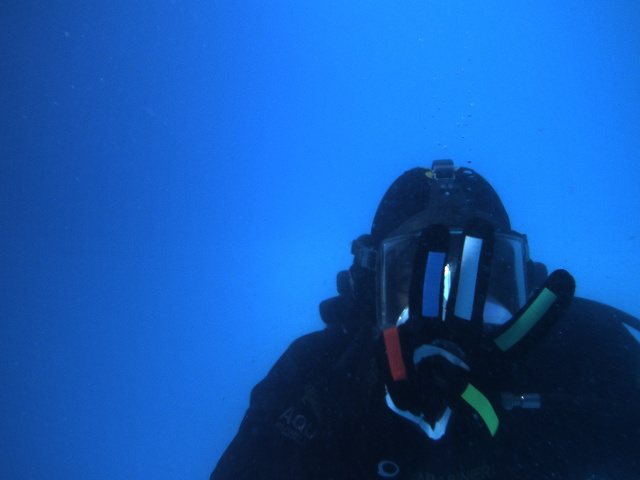

In [33]:
idx=100
img   = data_test['brodarski-A'].train_dl.dl.dataset.x[idx]
label = data_test['brodarski-A'].train_dl.dl.dataset.y[idx]
print(label, img.size)
img

carry torch.Size([480, 640])


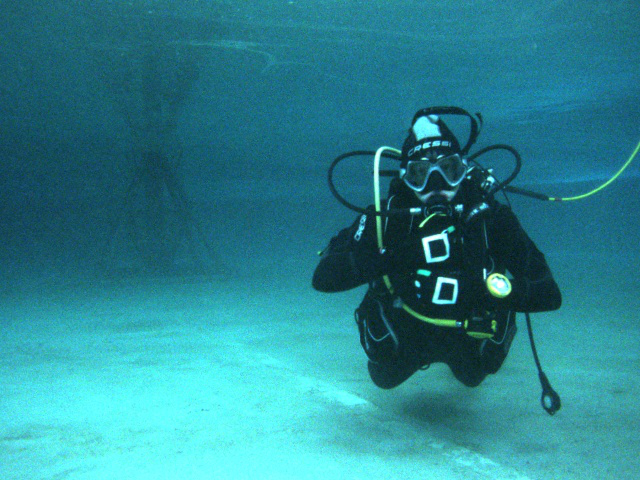

In [34]:
idx=102
img   = data_test['brodarski-A'].valid_dl.dl.dataset.x[idx]
label = data_test['brodarski-A'].valid_dl.dl.dataset.y[idx]
print(label, img.size)
img

In [35]:
print(learn.data, data, data_test)

ImageDataBunch;

Train: LabelList (5308 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
three,three,three,three,three
Path: caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B;

Valid: LabelList (1332 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
three,three,three,three,three
Path: caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B;

Test: None ImageDataBunch;

Train: LabelList (5308 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
three,three,three,three,three
Path: caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B;

Valid: LabelList (1332 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: Categ

# Let's first try the procedure on a single scenario

In [36]:
learn.data = data_test['genova-A']

KeyError: ignored

In [0]:
learn.data = data_test['brodarski-A']

In [38]:
print(learn.data, data, data_test)

ImageDataBunch;

Train: LabelList (5308 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
three,three,three,three,three
Path: caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test;

Valid: LabelList (454 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
boat,boat,boat,boat,boat
Path: caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B/test;

Test: None ImageDataBunch;

Train: LabelList (5308 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
three,three,three,three,three
Path: caddy-gestures-complete-v2-release-all-scenarios-fast.ai-split-model-B;

Valid: LabelList (1332 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: C

Plotting top losses for stage-1 (test set)


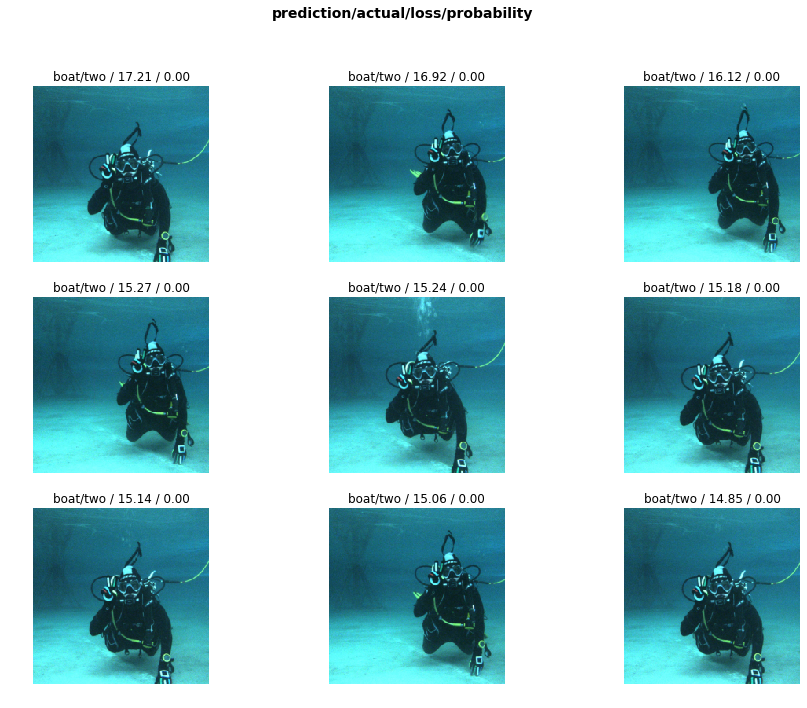

In [40]:
print('Interpreting result for stage-1 (test set)')
interp = ClassificationInterpretation.from_learner(learn)
print('Plotting top losses for stage-1 (test set)')
losses,idxs = interp.top_losses()
len(data_test['brodarski-A'].valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

Plotting confusion matrix/top confused for stage-1


[('two', 'boat', 61),
 ('start_comm', 'end_comm', 44),
 ('end_comm', 'boat', 42),
 ('start_comm', 'photo', 39),
 ('start_comm', 'boat', 32),
 ('carry', 'up', 20),
 ('here', 'boat', 17),
 ('end_comm', 'photo', 16),
 ('here', 'carry', 14),
 ('here', 'up', 11),
 ('here', 'end_comm', 8),
 ('num_delimiter', 'boat', 8),
 ('here', 'photo', 7),
 ('num_delimiter', 'photo', 5),
 ('start_comm', 'down', 4),
 ('boat', 'end_comm', 2),
 ('carry', 'boat', 2),
 ('carry', 'end_comm', 2),
 ('here', 'start_comm', 2),
 ('two', 'down', 2)]

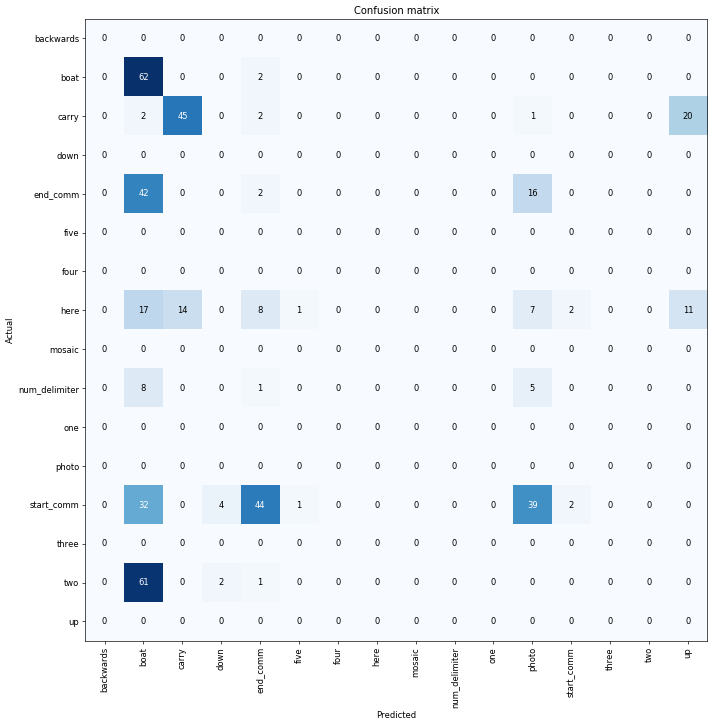

In [41]:
print('Plotting confusion matrix/top confused for stage-1')
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused(min_val=2)

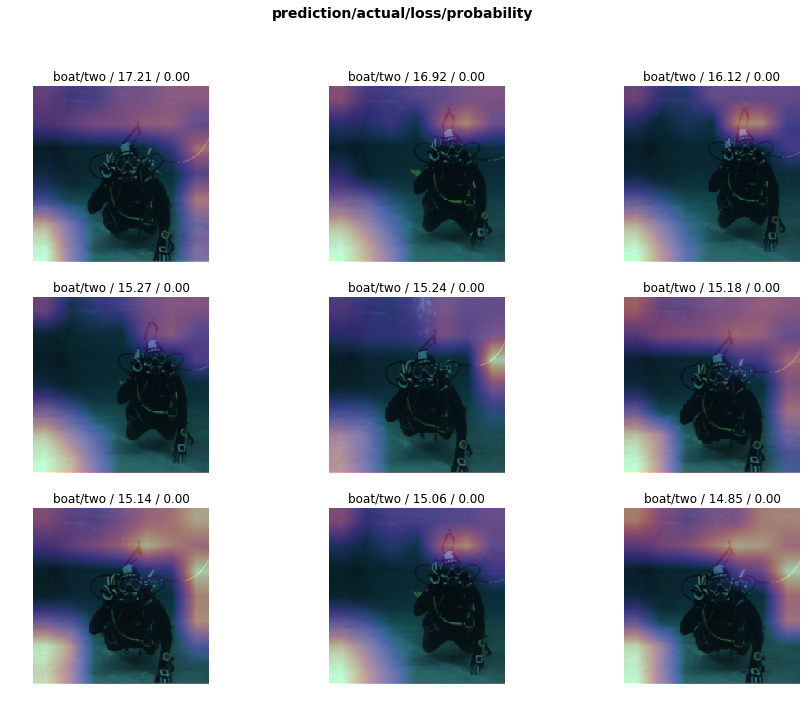

In [42]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

In [43]:
learn.show_results()

Output hidden; open in https://colab.research.google.com to view.

In [44]:
evaluate_model_from_interp(interp, data)

Interp has 454 ground truth labels: tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 12, 12, 12, 12,
    

0.2444933920704846

# Now, let's do it again in "batch mode" for all the test scenarios

In [45]:
accuracies = {}
accuracies[curr_model] = {}

for sc in scenarios + ['overall']:
    if sc not in models_specs[curr_model]['train']:
      
        print(80*'-')
        print(80*'-')
        print(80*'-')

        print(f'Selecting the test DataBunch data_test[{sc}]')
        
        data_t = data_test[sc]
        
        print(f'The dataset has {len(data_t.classes)} ({data_t.c}) classes: {data_t.classes}')
        print(f'Training   set size is: (x: {len(data_t.train_dl.dl.dataset.x)}, y: {len(data_t.train_dl.dl.dataset.y)})')
        print(f'Validation set size is: (x: {len(data_t.valid_dl.dl.dataset.x)}, y: {len(data_t.valid_dl.dl.dataset.y)})')
        
        learn.data = data_t
        
        print(f'Interpreting results for model-{curr_model} (test set) on scenario {sc}')
        interp = ClassificationInterpretation.from_learner(learn)
        losses,idxs = interp.top_losses()
        #interp.plot_top_losses(9, figsize=(15,11))
        
        print('Plotting confusion matrix/top confused for stage-1')
        #interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
        interp.most_confused(min_val=2)
        
        accuracies[curr_model][sc] = evaluate_model_from_interp(interp, data_t)

        print(f'End of testing for model-{curr_model} against test DataBunch {sc}')

        print(80*'-')
        print(80*'-')
        print(80*'-')


Plotting confusion matrix/top confused for stage-1
Interp has 11838 ground truth labels: tensor([13, 13, 13,  ..., 11, 11, 11])
Interp yielded 11838 raw predictions. First two raw predictions are: tensor([[1.7830e-06, 5.4701e-06, 8.2514e-06, 1.5496e-04, 3.0986e-05, 1.6295e-05,
         1.2594e-04, 8.9821e-07, 1.9242e-06, 3.1997e-07, 3.4139e-07, 1.4050e-03,
         2.7126e-06, 9.9794e-01, 7.8917e-05, 2.3014e-04],
        [2.8801e-03, 1.5148e-03, 8.2543e-02, 6.8879e-03, 5.6359e-02, 2.6966e-03,
         5.8317e-03, 4.1864e-03, 1.6093e-03, 7.0247e-01, 4.3230e-03, 6.4442e-02,
         4.2842e-02, 5.3640e-03, 3.7161e-03, 1.2335e-02]])
The problem had 16 classes: ['backwards', 'boat', 'carry', 'down', 'end_comm', 'five', 'four', 'here', 'mosaic', 'num_delimiter', 'one', 'photo', 'start_comm', 'three', 'two', 'up']

Pred -> GroundTruth = PredLabel -> GroundTruthLabel
13 -> 13 = three -> three
9 -> 13 = num_delimiter -> three
14 -> 13 = two -> three
1 -> 13 = boat -> three
14 -> 13 = two -> th

In [46]:
for sc in scenarios + ['overall']:
    if sc not in models_specs[curr_model]['train']:
        print(f'Accuracy for model-{curr_model} tested against scenario {sc}: {accuracies[curr_model][sc]:0.5f}')
        
accuracies_df = pd.DataFrame.from_dict(accuracies)

print(accuracies_df)
accuracies_df.to_csv('/content/accuracies-df-model-' + curr_model + '.csv')

Accuracy for model-B tested against scenario biograd-A: 0.42043
Accuracy for model-B tested against scenario biograd-B: 0.20564
Accuracy for model-B tested against scenario biograd-C: 0.45429
Accuracy for model-B tested against scenario brodarski-A: 0.24449
Accuracy for model-B tested against scenario brodarski-B: 0.12069
Accuracy for model-B tested against scenario brodarski-C: 0.21410
Accuracy for model-B tested against scenario brodarski-D: 0.48302
Accuracy for model-B tested against scenario overall: 0.36070
                    B
biograd-A    0.420428
biograd-B    0.205641
biograd-C    0.454294
brodarski-A  0.244493
brodarski-B  0.120690
brodarski-C  0.214101
brodarski-D  0.483025
overall      0.360703
